In [2]:
import numpy as np
import math
import cmath
import copy
import matplotlib.pyplot as plt

# TP4 : Echantillonnage compréssé

Dans ce TP, nous allons faire quelques expériences simples mettant en évidence expérimentalement qu'il est possible de résoudre un système d'équations avec plus d'inconnues que d'équations, dès lors que l'on sait que l'hypothèse de parcimonie est vérifiée.

Pour cela nous construirons un $x_0\in{\mathbb R}^{20}$ de parcimonie $K\leq 20$, une matrice aléatoire $M\in{\mathbb R}^{10\times 20}$ et une mesure $y=Mx_0$, de $x_0$. 

Nous mettrons en évidence que pour $K$ petit les algorithmes ci-dessous permettent souvent de reconstruire une solution proche de $x_0$, à partir de $y$, $M$ et $K$.
- la régularisation $\ell^1$
- la régularisation $\ell^0$
- l'algorithme "Orthogonal Matching Pursuit", du polycopié page 74


## Fonctions de base

Question 1 :  Dire ce que font chacune des fonctions ci-dessous.

In [3]:
def trouve_support(x,K):
    Nx = len(x)
    sorted_x = np.sort(abs(x))
    seuil = sorted_x[Nx-K]
    
    s = ( abs(x) >= seuil )
    
    return s
    
#############################

def trouve_support_size_unknown(x):
   
    s = ( abs(x) >= 0.000001 )
    
    return s
    
#############################

def compare_support(x,x_true,K):
    s = trouve_support(x,K)
    s_true = trouve_support(x_true,K)
    
    Nx = len(x)
    supports_are_equal = True
    for i in range(Nx):
        if s[i] != s_true[i]:
            supports_are_equal = False
            
    return supports_are_equal
    
#############################

def size_intersection_support(x,x_true):
    s = trouve_support_size_unknown(x)
    s_true = trouve_support_size_unknown(x_true)
    
    Nx = len(x)
    size_intersection = 0
    for i in range(Nx):
        if s[i] == True and s_true[i] == True:
            size_intersection += 1
            
    return size_intersection
    
#############################

def support_distance(x,x_true):
    s = trouve_support_size_unknown(x)
    s_true = trouve_support_size_unknown(x_true)
    
    Nx = len(x)
    dist = 0
    for i in range(Nx):
        if s[i] != s_true[i] :
            dist += 1
            
    return dist
    
#############################

def gen_x(Nx,n,u_type):
    
    u = np.zeros(Nx)   # par defaut des 0
    
    if u_type == 1: # un dirac en n
        if n>=0 and n <Nx: 
            u[n] = 1
    if u_type == 2: # un signal n-sparse
        u = np.random.normal(0,1,Nx) 
        x = np.random.normal(0,1,Nx) 
        s = trouve_support(x,n)
        u = u * s

    if u_type == 3: # un signal n-sparse de coordonnees uniforme dans [-2,-1]cup[1,2]
        u = np.random.uniform(-1,1,Nx) 
        for i in range(Nx):
            if u[i]>0:
                u[i] +=1
            else:
                u[i] -=1
                
        x = np.random.normal(0,1,Nx) 
        s = trouve_support(x,n)
        u = u * s
        
        
    return u
    
#############################

def gen_matrix(Nx,Ny,M_type):
    
    M = np.zeros((Ny,Nx))   # defaut
    
    if M_type == 0 : # aleatoire
        M = np.random.normal(0,1,(Ny,Nx)) 
                 
    if M_type == 1 : # Identite
        for i in range(min(Nx,Ny)):
            M[i,i] = 1

    return M
    
#############################

def operateur(M,x,adjoint):
    
    if adjoint == 0 :
        y = M @ x 
    
    if adjoint == 1 :   
        y = M.T @ x
    
    return y
    
#############################

def compute_L(M,x):
    Nx = len(x)
    u = np.random.normal(0,1,Nx) 
    nbIter = 100
    
    for it in range(nbIter):
        v = operateur(M,u,0)
        u = operateur(M,v,1)
        L2 = np.linalg.norm(u)
        u = u / L2
    
    return math.sqrt(L2)
    

## Algorithme du gradient proximal pour la régularisation $\ell^1$

Question 2 : Faire le lien entre l'algorithme ci-dessous et l'algorithme du gradient proximal (polycopié page 23 et page 73) permettant de minimiser en $$\mu \|x\|_1 +\|Mx-y\|_2^2$$

In [4]:
def seuil_doux(x,seuil):
    
    y = (x > seuil) * (x-seuil) + ( x < -seuil) * (x+seuil) 
    
    return y

def regularisation_l1(M,y,mu,nbIter):
    (Ny,Nx) = np.shape(M)

    x = np.zeros(Nx)
    L = compute_L(M,x)
    pas = 1/(L*L)
    
    for it in range(nbIter):
        g = 2 * operateur(M, ( operateur(M,x,0) - y ) , 1 ) # gradient
        x = x - pas * g                           # gradient step
        x = seuil_doux(x,mu*pas)                      # prox

    return x


Question 3 : Décrire l'expérience ci-dessous et la lancer plusieurs fois pour trouver la valeur de $\mu$ permettant de trouver (la plupart du temps) une solution $x$ proche de $x_0$.

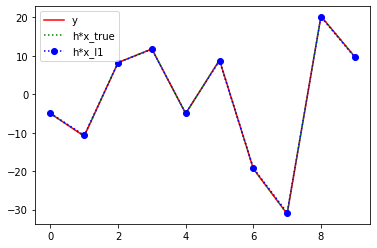

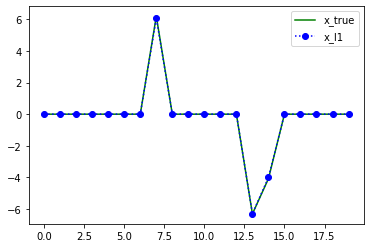

In [6]:
# reg_l1
Nx=20
Ny=10
K=3
mu=3
sigma = 0.
nbIter = 200

x_true = 10 * gen_x(Nx,K,2)
M = gen_matrix(Nx,Ny,0)
y = operateur(M,x_true,0) + sigma * np.random.normal(0,1,Ny) 
x = regularisation_l1(M,y,mu,nbIter)
#display(M)
#display(y)
#display(x_true)
#display(x)

plt.figure(1)
plt.plot(y,"r" , label="y")
plt.plot( operateur(M,x_true,0), "g:" , label="h*x_true")
plt.plot( operateur(M,x,0), "b:o",label="h*x_l1" )
plt.legend()
#######################

plt.figure(2)

plt.plot( x_true, "g-" , label="x_true")
plt.plot( x, "b:o",label="x_l1" )
plt.legend()

## Algorithme du gradient proximal pour la régularisation $\ell^0$

Question 4 : On considère la minimisation de $$R(x) +\|Mx-y\|_2^2$$ où
$$R(x) = \left\{\begin{array}{ll}
+\infty & \mbox{si } \ell^0(x)>K \\
0 & \mbox{sinon.}
\end{array}\right.
$$

Montrer que, pour tout $t$, $prox_{R}^t(x)$ consiste à prendre les $K$ entrées de $x$, les plus grandes en valeur absolue.

Question 5 : Compléter le code ci-dessous pour qu'il cherche un minimiseur de $$R(x) +\|Mx-y\|_2^2$$

In [5]:
def regularisation_l0(M,y,K,nbIter):
    (Ny,Nx) = np.shape(M)

    x = np.zeros(Nx)
    L = compute_L(M,x)
    pas = 0.9/(L*L)
    
    for it in range(nbIter):
        g = 2 * operateur(M, ( operateur(M,x,0) - y ) , 1 ) # gradient
        x = x - pas * g                           # gradient step
        x =    # prox A ECRIRE

    return x


Question 6 : Décrire l'expérience ci-dessous et la lancer plusieurs fois pour trouver un problème pour lequel $x$ est proche de $x_0$.

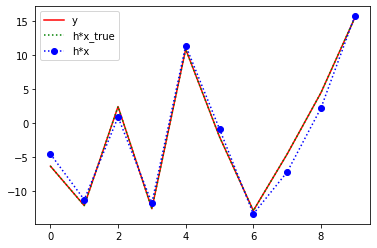

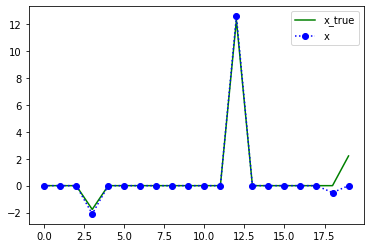

In [6]:
# palm_l0
Nx=20
Ny=10
K=3
sigma = 0.
nbIter = 200

x_true = 10 * gen_x(Nx,K,2)
M = gen_matrix(Nx,Ny,0)
y = operateur(M,x_true,0) + sigma * np.random.normal(0,1,Ny) 
x = regularisation_l0(M,y,K,nbIter)
#display(M)
#display(y)
#display(x_true)
#display(x)

plt.figure(1)
plt.plot(y,"r" , label="y")
plt.plot( operateur(M,x_true,0), "g:" , label="h*x_true")
plt.plot( operateur(M,x,0), "b:o",label="h*x" )
plt.legend()
#######################

plt.figure(2)

plt.plot( x_true, "g-" , label="x_true")
plt.plot( x, "b:o",label="x" )
plt.legend()


## Orthogonal Matching Pursuit

Question 7 : Faire le lien entre l'algorithme ci-dessous et l'orthogonal Matching Pursuit décrit page 74 du polycopié.

In [7]:
def OMP(M,y,K,nbIter):
    (Ny,Nx) = np.shape(M)

    x = np.zeros(Nx)
    s = np.zeros(Nx)
    L = compute_L(M,x)
    pas = 0.9/(L*L)
    
    for k in range(K):
        g = 2 * operateur(M, ( operateur(M,x,0) - y ) , 1 ) # gradient
        i_max = np.argmax(np.abs(g))
        s[i_max] = 1
        for it in range(nbIter):
            g = 2 * operateur(M, ( operateur(M,x,0) - y ) , 1 ) # gradient
            x = x - pas * g * s   # projection

    return x


Question 8 : A nouveau, décrire l'expérience ci-dessous et la lancer plusieurs fois pour trouver un problème pour lequel $x$ est proche de $x_0$.

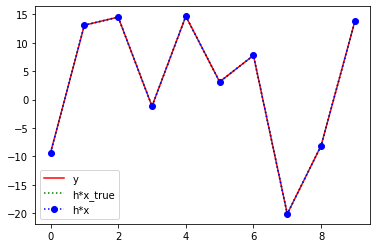

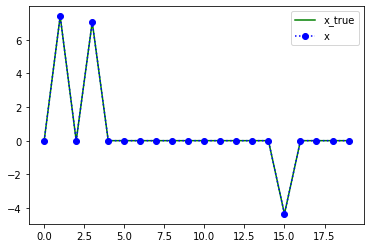

In [8]:
# OMP
Nx=20
Ny=10
K=3
sigma = 0.
nbIter = 200

x_true = 10 * gen_x(Nx,K,2)
#h = gen_filter(Nh,2)     #Pour debugger, on prend h = un dirac
M = gen_matrix(Nx,Ny,0)      #Pour trouver des difficiles, on prend h = 1, nh=6, avec Nx = 10
y = operateur(M,x_true,0) + sigma * np.random.normal(0,1,Ny) 
x = OMP(M,y,K,nbIter)
#display(M)
#display(y)
#display(x_true)
#display(x)

plt.figure(1)
plt.plot(y,"r" , label="y")
plt.plot( operateur(M,x_true,0), "g:" , label="h*x_true")
plt.plot( operateur(M,x,0), "b:o",label="h*x" )
plt.legend()
#######################

plt.figure(2)

plt.plot( x_true, "g-" , label="x_true")
plt.plot( x, "b:o",label="x" )
plt.legend()


## Comparaison des algorithmes

Question 9 : En lancant l'expérience ci-dessous plusieurs fois, vous constaterez que, pour une configuration de problème donnée, les différents algorithmes ci-dessous retournent une solution proche de $x_0$ avec une certaine probabilité. Dans la suite, vous considérerez que l'algorithme a résolu un problème lorsqu'il aboutit à une erreur plus faible que $\varepsilon = 1$.

Evaluer, pour $K=1, 2, 3, 4, 5, 6 $ et $7$ et $N_y=10$ et $15$ la probabilité de succès des différents algorithmes (pour des matrices aléatoires Gaussiennes et des $x_0$ générés comme ci-dessous).

Commentez les résultats obtenus.

Quel algorithme recommandez vous ?

In [9]:
Nx=20
Ny=15
K=3
mu = 3
sigma = 0.
nbIter = 200

x_true = 10 * gen_x(Nx,K,2)
#h = gen_filter(Nh,2)     #Pour debugger, on prend h = un dirac
M = gen_matrix(Nx,Ny,0)      #Pour trouver des difficiles, on prend h = 1, nh=6, avec Nx = 10
y = operateur(M,x_true,0) + sigma * np.random.normal(0,1,Ny) 

# reconstruction
x_l0 = regularisation_l0(M,y,K,nbIter)
x_omp = OMP(M,y,K,nbIter)
x_l1 = regularisation_l1(M,y,mu,nbIter)
print("erreur regularisation_L0 = ",np.linalg.norm(x_l0 - x_true))
print("erreur OMP = ",np.linalg.norm(x_omp - x_true))
print("erreur regularisation_L1 = ",np.linalg.norm(x_l1 - x_true))

# Display
plt.figure(1)
plt.plot(y,"r" , label="y")
plt.plot( operateur(M,x_true,0), "g-*" , label="h*x_true")
plt.plot( operateur(M,x_l0,0), "b:o",label="h*x_l0" )
plt.plot( operateur(M,x_omp,0), "m:o",label="h*x_omp" )
plt.plot( operateur(M,x_l1,0), "y:o",label="h*x_l1" )

plt.legend()
#######################

plt.figure(2)

plt.plot( x_true, "g-*" , label="x_true")
plt.plot( x_l0, "b:o" , label="x_l0")
plt.plot( x_omp, "m:o",label="x_omp" )
plt.plot( x_l1, "y:o",label="x_l1" )

plt.legend()


NameError: name 'regularisation_l0' is not defined

In [11]:
# Test Massif A ECRIRE


Pour K =  2
L0 marche  dans  76.4 % des cas
OMP marche  dans  92.4 % des cas
L1 marche  dans  90.0 % des cas
